In [1]:
from cmath import sqrt
import matplotlib.colors 
import matplotlib.ticker
import matplotlib.pyplot as plt
import random
import numpy as np
import collections
from numpy.core.fromnumeric import argsort
from sklearn.manifold import TSNE
from scipy.linalg import svd
import torch
import matplotlib.patches as mpatches
import math
import random as rd
import matplotlib.cm as cm
import os

# define functions

def helper_load_train(filename):
    user_dict_list = {}
    item_dict = set()
    item_dict_list = {}
    trainUser, trainItem = [], []

    with open(filename) as f:
        for line in f.readlines():
            line = line.strip('\n').split(' ')
            if len(line) == 0:
                continue
            line = [int(i) for i in line]
            user = line[0]
            items = line[1:]
            item_dict.update(items)
            # LGN
            trainUser.extend([user] * len(items))
            trainItem.extend(items)
            if len(items) == 0:
                continue
            user_dict_list[user] = items

            for item in items:
                if item in item_dict_list.keys():
                    item_dict_list[item].append(user)
                else:
                    item_dict_list[item] = [user]

    return user_dict_list, item_dict, item_dict_list, trainUser, trainItem

def get_rotation_matrix(axis, theta):
    """
    Find the rotation matrix associated with counterclockwise rotation
    about the given axis by theta radians.
    Credit: http://stackoverflow.com/users/190597/unutbu

    Args:
        axis (list): rotation axis of the form [x, y, z]
        theta (float): rotational angle in radians

    Returns:
        array. Rotation matrix.
    """

    axis = np.asarray(axis)
    theta = np.asarray(theta)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

def ensureDir(dir_path):

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
def angle_90(vec1, vec2):
    unit_vec1 = vec1 / np.linalg.norm(vec1)
    unit_vec2 = vec2 / np.linalg.norm(vec2)
    dot_product = np.dot(unit_vec1, unit_vec2)
    angle = np.arccos(dot_product)
    angle = abs(0.5*math.pi-angle)
    return angle

In [2]:
def load_checkpoint_one(epoch):

    checkpoint = torch.load("epoch={}.checkpoint.pth.tar".format(epoch), map_location='cpu')

    for parameter in checkpoint['state_dict']:

        if parameter == 'embed_user.weight':
            user_ID = checkpoint['state_dict'][parameter]

        elif parameter == 'embed_item.weight':
            item_ID = checkpoint['state_dict'][parameter]

        elif parameter == 'embed_user_pop.weight':
            user_pop = checkpoint['state_dict'][parameter]

        elif parameter == 'embed_item_pop.weight':
            item_pop = checkpoint['state_dict'][parameter]
            
    return user_ID, item_ID, user_pop, item_pop

In [3]:
def load_checkpoint_two(epoch_ID, epoch_pop):

    checkpoint_ID = torch.load("epoch={}.checkpoint.pth.tar".format(epoch_ID), map_location='cpu')
 
    checkpoint_pop = torch.load("epoch={}.checkpoint.pth.tar".format(epoch_pop), map_location='cpu')

    for parameter in checkpoint_ID['state_dict']:

        if parameter == 'embed_user.weight':
            user_ID = checkpoint_ID['state_dict'][parameter].cpu().detach().numpy()

        elif parameter == 'embed_item.weight':
            item_ID = checkpoint_ID['state_dict'][parameter].cpu().detach().numpy()

    for parameter in checkpoint_pop['state_dict']:

        if parameter == 'embed_user_pop.weight':
            user_pop = checkpoint_pop['state_dict'][parameter].cpu().detach().numpy()

        elif parameter == 'embed_item_pop.weight':
            item_pop = checkpoint_pop['state_dict'][parameter].cpu().detach().numpy()
            
    return user_ID, item_ID, user_pop, item_pop


In [4]:
# load data 
train_user_list, _, train_item_list, _, _ = helper_load_train("./data/yelp2018.reduced/train.txt")
valid_user_list, _, valid_item_list, _, _ = helper_load_train("./data/yelp2018.reduced/valid.txt")
test_id_user_list, _, test_id_item_list, _, _ = helper_load_train("./data/yelp2018.reduced/test_id.txt")
test_ood_user_list, _, test_ood_item_list, _, _ = helper_load_train("./data/yelp2018.reduced/test_ood.txt")

n_users = len(list(train_user_list.keys()))
n_items = len(list(train_item_list.keys()))
pop_user = {key: len(value) for key, value in train_user_list.items()}
pop_item = {key: len(value) for key, value in train_item_list.items()}
sorted_pop_user = list(set(list(pop_user.values())))
sorted_pop_user.sort()
sorted_pop_item = list(set(list(pop_item.values())))
sorted_pop_item.sort()
user_idx, item_idx = {}, {}
for i, it in enumerate(sorted_pop_user):
    user_idx[it] = i
for i, it in enumerate(sorted_pop_item):
    item_idx[it] = i
user_pop_idx = np.zeros(n_users, dtype=int)
item_pop_idx = np.zeros(n_items, dtype=int)
for key, value in pop_user.items():
    user_pop_idx[key] = user_idx[value]
for key, value in pop_item.items():
    item_pop_idx[key] = item_idx[value]

max_length = 0
max_user = 0
for key, value in train_user_list.items():
    if len(value) > max_length:
        max_length = len(value)
        max_user = key

In [5]:
import operator
pop_user = {key: len(value) for key, value in train_user_list.items()}
sorted_pop_user = dict(sorted(pop_user.items(), key=operator.itemgetter(1),reverse=True))
sorted_users = np.array(list(sorted_pop_user.keys()))
each_chunk = int(len(sorted_users)/50)
temp = list(np.linspace(each_chunk,each_chunk*49,49))
temp = [int(x) for x in temp]
chunks = np.split(sorted_users,temp)

import pandas as pd
users = []
for i in range(0, len(chunks)):
    chunk = chunks[i]
    if i == 0:
        for j in range(0, 10):
            users.append(chunk[j])
    if i <3:
        n = 10
    elif i > 20:
        n = 1
    else:
        n = 2
    index = np.random.choice(chunk.shape[0], n, replace=False)
    for item in index:
        users.append(item)
    
populations = []
for user in users:
    populations.append(pop_user[user])
    
df = pd.DataFrame(data = {'index':users, 'pop':populations})
df = df.sort_values(by = 'pop', ascending = False)
df = df.drop_duplicates()
users = df['index'].tolist()
pops = df['pop'].tolist()

In [6]:
user_ID, item_ID, user_pop, item_pop = load_checkpoint_one(179)

In [7]:
def draw_pictures(selected_user, user_frequency, folder_name, \
                  user_ID = user_ID, user_pop = user_pop,  item_ID = item_ID, item_pop = item_pop, \
                  user_pop_idx = user_pop_idx,\
                    item_pop_idx = item_pop_idx, \
                  train_user_list = train_user_list):

    fig = plt.figure(figsize=(14,10),constrained_layout=True)
    gs = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[0:3, 0:3],projection='3d')
    ax1.set_xticks([-0.5,0,0.5])
    ax1.set_xlim(-0.65,0.65)
    ax1.set_yticks([-0.5,0,0.5])
    ax1.set_ylim(-0.65,0.65)
    ax1.set_zticks([-0.5,0,0.5])
    ax1.set_zlim(-0.65,0.65)
    ax1.axis(False)

    u, v = np.mgrid[0:2*np.pi:40j, 0:2*np.pi:40j]
    x1 = np.cos(u)*np.sin(v)
    y1 = np.sin(u)*np.sin(v)
    z1 = np.cos(v)
    ax1.plot_wireframe(x1, y1, 1.25*z1, color="0.8",linewidth=0.5,alpha=1)

    cmap_b = 'navy'
    cmap_r = 'darkred'

    cmaps=[cmap_r,cmap_b]

    norm = plt.Normalize(vmin=-3, vmax=3)

    # without disentanglement

    # userID and userpop
    max_user = selected_user
    user = user_ID[max_user]

    # rotate
    base_point = [-3.6, 3, 0.3]
    base_point = base_point/np.linalg.norm(base_point)
    target=base_point
    r_theta=np.arccos(np.dot(user,target)/(np.linalg.norm(user)*np.linalg.norm(target)))
    axis=np.cross(user,target)
    R=get_rotation_matrix(axis,r_theta)

    user=np.matmul(user,R.T)
    norm=np.linalg.norm(user)
    user = user/norm
    ax1.plot([0,user[0]],[0,user[1]],[0,user[2]], c = cmaps[0])
    ax1.scatter(user[0], user[1], user[2], c = np.array([200]), cmap='Reds_r', marker ="*",s=300, label = 'User preference')

    user_pop_point = user_pop[user_pop_idx[max_user]]
    user_pop_point = np.matmul(user_pop_point,R.T)
    norm=np.linalg.norm(user_pop_point)
    user_pop_point = user_pop_point/norm

    ax1.plot([0,user_pop_point[0]],[0,user_pop_point[1]],[0,user_pop_point[2]],color = cmaps[1])
    ax1.scatter(user_pop_point[0], user_pop_point[1], user_pop_point[2],c = np.array([100]),  cmap='Blues_r', marker ="*",s=300, label = 'User conformity')

    # get two clusters of items
    # property
    item_ID_w= item_ID[train_user_list[max_user]]
    item_pop_w = item_pop[item_pop_idx[train_user_list[max_user]]]

    item_population = []
    for item in train_user_list[max_user]:
        pop = pop_item[item]
        
        item_population.append(math.log(pop))

    item_ID_w = np.matmul(item_ID_w,R.T)

    item_ID_w = item_ID_w/np.expand_dims(np.linalg.norm(item_ID_w, axis = 1), axis = 1)
    x = item_ID_w[:, :1]
    y = item_ID_w[:, 1:2]
    z = item_ID_w[:, 2:]
    colors = np.array(item_population)
    
    ax1.scatter(x[0], y[0], z[0], c = colors[0], cmap='Reds_r', marker =".",s=20, label = 'Item property')
   
    ax1.scatter(x, y, z, c = colors, cmap='Reds', marker =".",s=50)
    

    # popularity
    item_pop_w = np.matmul(item_pop_w,R.T)
    item_pop_w = item_pop_w/np.expand_dims(np.linalg.norm(item_pop_w, axis = 1), axis = 1)
    x = item_pop_w[:, :1]
    y = item_pop_w[:, 1:2]
    z = item_pop_w[:, 2:]
    
    ax1.scatter(x[0], y[0], z[0], c = colors[0], cmap='Blues_r', marker =".",s=20, label = 'Item popularity')
    ax1.scatter(x, y, z, c = colors, cmap='Blues', marker =".",s=50)
    
    ax1.scatter(0, 0, 0, c = 'midnightblue', marker =".",s=50)
   
    plt.legend(loc = 'upper right', bbox_to_anchor=(1.05, 1.))
    
    PCM=ax1.get_children()[6]
    PCM2=ax1.get_children()[4]
    clb = plt.colorbar(PCM, fraction=0.04,shrink=0.8, ax=ax1, location = "right")
    clb2 = plt.colorbar(PCM2, fraction=0.04,shrink=0.8, ax=ax1, location = "right")
    clb.ax.get_yaxis().labelpad = 15
    clb.ax.set_ylabel('Log(#interactions)', fontsize=20, labelpad=20, rotation=270)
            
    ensureDir(folder_name)
    #plt.tight_layout()
    plt.savefig('{}/pop={}_index={}.pdf'.format(folder_name, user_frequency, max_user), format="pdf",bbox_inches='tight')
    #plt.savefig('index={}.png'.format(max_user))


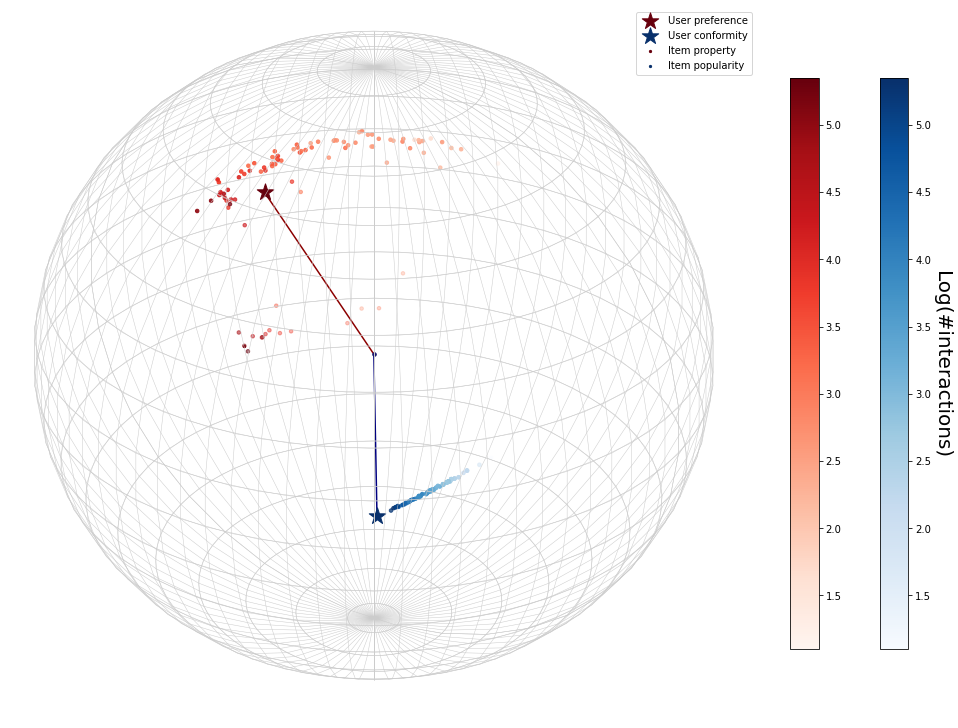

In [8]:
draw_pictures(selected_user = 68, user_frequency = 91, folder_name = 'DEBIAS_NEW',
                 user_ID = user_ID, user_pop = user_pop, item_ID = item_ID, item_pop = item_pop)